<a href="https://colab.research.google.com/github/Michel-p16/PDS-Project/blob/capstone_korbi/aktuellste_version_distilmulti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#connect drive
from google.colab import drive
drive.mount('/content/drive')

# Pfad zum neuen Multi-Select-Dataset
dataset_path_multi = '/content/drive/My Drive/ColabData/final_multi_question_data.json'

# Laden des neuen Datensatzes
import json
with open(dataset_path_multi, 'r') as file:
    dataset_multi = json.load(file)

# Laden des single Datensatzes
dataset_path_single = '/content/drive/My Drive/ColabData/final_single_question_data.json'
with open(dataset_path_single, 'r') as file:
    dataset_single = json.load(file)


!pip install transformers datasets
#1. Daten laden + filtern (MULTI SELECT here)
import json
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

import os

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn

# Filtere das Dataset nach Fragen mit dem Typ "MULTI_SELECT"
filtered_dataset_multi = [example for example in dataset_multi if example["type"] == "MULTI_SELECT"]




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
#2. Daten formatieren (diesmal inkl Fragen Einbezug für training) -> binäre vektoren durch MultiLabelBinarizer

from sklearn.preprocessing import MultiLabelBinarizer

# Labels direkt in Float32 konvertieren
def convert_to_multi_select_format(data, mlb):
    formatted_data = []

    for example in data:
        question = example["question"]
        answers = example["answers"]

        for answer in answers:
            text = answer.get("answer_text", "")
            labels = answer.get("answer_label", "").split(",")

            # Labels bereinigen
            labels = [label.strip() for label in labels]

            if labels:  # Falls Labels vorhanden sind
                label_vector = mlb.transform([labels])[0]  # Binärvektor
                label_vector = label_vector.astype(float)  # **Hier direkt in float konvertieren!**

                formatted_data.append({
                    "question": question,  # Frage bleibt erhalten
                    "text": text,  # Antwort bleibt erhalten
                    "labels": label_vector  # Labels nun als float
                })

    return formatted_data



# Alle eindeutigen Labels aus dem Datensatz sammeln
all_labels = set()
for example in filtered_dataset_multi:
    for answer in example["answers"]:
        labels = answer.get("answer_label", "").split(",")
        labels = [label.strip() for label in labels]  # Führende/nachfolgende Leerzeichen entfernen
        all_labels.update(labels)

# MultiLabelBinarizer initialisieren
multi_label_binarizer = MultiLabelBinarizer(classes=sorted(list(all_labels)))  # Sortiert für Konsistenz
multi_label_binarizer.fit([list(all_labels)])

# Daten formatieren
formatted_multi_dataset = convert_to_multi_select_format(filtered_dataset_multi, multi_label_binarizer)

# Überprüfung der Ergebnisse
print(f"Anzahl der formatierten Beispiele: {len(formatted_multi_dataset)}")
if formatted_multi_dataset:
    print(f"Beispiel: {formatted_multi_dataset[0]}")
print(f"Alle möglichen Labels: {multi_label_binarizer.classes_}")


Anzahl der formatierten Beispiele: 745
Beispiel: {'question': 'What are your product interests?', 'text': "I'm interested in improving data quality and generating business cards.", 'labels': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])}
Alle möglichen Labels: ["'Angelina Haug'" "'Domiki Stein'" "'Erik Schneider'" "'Jens Roschmann'"
 "'Jessica Hanke'" "'Joachim Wagner'" "'Johannes Wagner'" "'Marisa Peng'"
 "'Oliver Eibel'" "'Sandro Kalter'" "'Sean Kennin'" "'Stephan Maier'"
 "'Tim Persson'" '1 week' '100' '2 weeks' '200' '234' '256' '3 weeks'
 '300' 'AKW100' 'AX100' 'Automotive radar target simulation'
 'BusinessCards' 'Capture trade fair contacts' 'Clean up CRM' 'Competitor'
 'Data Cleansing' 'DataEnrichment' 'DataQuality'
 'Display port debugging and compliance' 'Double-Pulse Testing' 'Email'

In [36]:
#3. Daten splitten + formatieren in Hugging Face Dataset

#Split 80/20
train_data_multi_formatted, eval_data_multi_formatted = train_test_split(formatted_multi_dataset, test_size=0.2, random_state=42)

# Multi-Label-Trainings- und Evaluations-Dataset erstellen
train_dataset_multi = Dataset.from_pandas(pd.DataFrame(train_data_multi_formatted))
eval_dataset_multi = Dataset.from_pandas(pd.DataFrame(eval_data_multi_formatted))

# Überprüfung der Datenmengen
print(f"Anzahl der Trainingsdaten: {len(train_dataset_multi)}")
print(f"Anzahl der Evaluationsdaten: {len(eval_dataset_multi)}")

Anzahl der Trainingsdaten: 596
Anzahl der Evaluationsdaten: 149


In [37]:
#4. Dataset vorverarbeitung

from transformers import AutoTokenizer
import torch
from datasets import Dataset

# Tokenizer initialisieren
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Vorverarbeitungsfunktion für Multi-Label-Daten
def preprocess_function_multi(examples):
    return tokenizer(
        examples["question"],  # Frage
        examples["text"],      # Antwort
        padding="max_length",
        truncation=True,
        max_length=128  # Falls nötig, auf 128 erhöht
    )

# Tokenizer-Funktion an
train_dataset_multi = train_dataset_multi.map(preprocess_function_multi, batched=True)
eval_dataset_multi = eval_dataset_multi.map(preprocess_function_multi, batched=True)

# PyTorch-kompatibles Format setzen
train_dataset_multi.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
eval_dataset_multi.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Struktur überprüfen
print(train_dataset_multi[0])
print(train_dataset_multi[0]["labels"])  # Sollte ein Float-Tensor sein
print(train_dataset_multi[0]["labels"].dtype)  # Erwartet: torch.float32



Map:   0%|          | 0/596 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

{'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'input_ids': tensor([  101,  2054,  2024,  2115,  4031,  5426,  1029,   102,  1045,  2342,
         1037,  6994,  2005,  4372, 13149,  2075,  2026,  8013,  2951,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 

In [38]:
#5. PyTorch-kompatibles Format setzen
train_dataset_multi.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
eval_dataset_multi.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


In [7]:
#6. Training

import pickle
from sklearn.metrics import precision_recall_fscore_support
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import torch.nn.functional as F
import torch

# Loss-Funktion für Multi-Label-Klassifikation
def custom_loss(predictions, labels):
    return F.binary_cross_entropy_with_logits(predictions, labels)

# Eigene Trainer-Klasse mit angepasster Loss-Funktion
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")  # Entferne Labels aus Inputs
        outputs = model(**inputs)      # Modell-Vorhersagen
        logits = outputs.logits        # Logits extrahieren
        loss = custom_loss(logits, labels)  # BCEWithLogitsLoss berechnen
        return (loss, outputs) if return_outputs else loss

# Modell initialisieren (Multi-Label-Modus)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(multi_label_binarizer.classes_),  # Anzahl der Labels
    problem_type="multi_label_classification"  # WICHTIG für Multi-Label
)

# Speichern des Label-Mappings für späteres Decoding
label_mapping = {idx: label for idx, label in enumerate(multi_label_binarizer.classes_)}
inverse_label_mapping = {label: idx for idx, label in enumerate(multi_label_binarizer.classes_)}

label_mapping_path = "/content/drive/My Drive/label_mapping_multi_wQ.pkl"
with open(label_mapping_path, "wb") as file:
    pickle.dump(label_mapping, file)

print("Label-Mapping erfolgreich gespeichert.")


# Anpassung der Metriken (für Multi-Label Klassifikation)
def compute_metrics(pred):
    labels = pred.label_ids  # Wahre Labels
    preds = torch.sigmoid(torch.tensor(pred.predictions)) > 0.5  # Wahrscheinlichkeiten -> Binärwerte

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds.numpy(), average="weighted"
    )
    acc = (preds.numpy() == labels).all(axis=1).mean()  # Beispielgenauigkeit

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

# TrainingArgs
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=25,
    learning_rate=5e-5,
    weight_decay=0.01,  # tried .05 -> worse
    #adam_beta1=0.9, #senken falls langsam reaktion
    #adam_beta2=0.999, #senekn bei wenig lernprogress
    #adam_epsilon=1e-6,  # erhöhen falls instabil
    #label_smoothing_factor=0.1,  #bessere Generalisierung
    evaluation_strategy="epoch",  # eval pro epoch
    save_strategy="epoch",  # save pro epoch
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",  # ausgeschaltet, weil kein Zugriff zu repo
    logging_steps=10,  # Alle 10 Schritte loggen
)

# Early Stopping Callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=1,  # stop at 1 epoch worse
    early_stopping_threshold=0.000  #  min same
)



# Trainer-Objekt erstellen
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_multi,
    eval_dataset=eval_dataset_multi,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

# Training starten
trainer.train()

# Modell und Tokenizer speichern
save_path = "/content/drive/My Drive/multi_distilbert_wQ"
os.makedirs(save_path, exist_ok=True)  # Erstelle den Pfad, falls er nicht existiert
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Das Modell wurde erfolgreich gespeichert.")



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Label-Mapping erfolgreich gespeichert.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.155400,0.144671,0.000000,0.000000,0.000000,0.000000
2,0.105800,0.096253,0.053691,0.107475,0.118172,0.110368
3,0.078200,0.072442,0.127517,0.367418,0.450304,0.357860
4,0.064300,0.058009,0.241611,0.501351,0.560340,0.488294
5,0.054500,0.051477,0.322148,0.546684,0.688350,0.501672
6,0.039700,0.043218,0.416107,0.696597,0.753462,0.692308
7,0.030300,0.035290,0.583893,0.786696,0.836965,0.769231
8,0.030600,0.029538,0.644295,0.791799,0.824725,0.782609
9,0.022600,0.026515,0.671141,0.841609,0.911120,0.812709
10,0.015800,0.024476,0.718121,0.863325,0.940241,0.836120


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

Metriken wurden erfolgreich unter /content/drive/My Drive/distilMulti_training_metrics.csv gespeichert.
Das Modell wurde erfolgreich gespeichert.


In [7]:
import pandas as pd

# Extrahiere die Training-Metriken aus dem Trainer
metrics_df = pd.DataFrame(trainer.state.log_history)

# Pfad für die CSV-Datei in Google Drive
multi_metrics_csv_path = "/content/drive/My Drive/training_metrics_distilbert_multi_select.csv"

# Speichere die Metriken als CSV
metrics_df.to_csv(multi_metrics_csv_path, index=False)

print(f"Training metrics saved to {multi_metrics_csv_path}")


NameError: name 'trainer' is not defined

In [39]:
#7. manueller test

import torch
import random
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Modell & Tokenizer laden
model_path = "/content/drive/My Drive/multi_distilbert_wQ"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Label Mapping laden
label_mapping_path = "/content/drive/My Drive/label_mapping_multi_wQ.pkl"
with open(label_mapping_path, "rb") as file:
    label_mapping = pickle.load(file)

# Fragen aus dem Dataset extrahieren
all_questions = list(set(example["question"] for example in dataset_multi))

# 5 Zufällige Frage auswählen
selected_questions = random.sample(all_questions, 5)

# Evaluation für jede Frage
for idx, question in enumerate(selected_questions, start=1):
    print(f"Frage {idx}: {question}")

    # Manuelle Eingabe der Antwort
    user_answer = input("Bitte geben Sie eine Antwort ein: ")

    # Eingabe tokenisieren (Frage + Antwort)
    inputs = tokenizer(
        question,  # Frage
        user_answer,  # Antwort
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )

    # Modellvorhersage (ohne Gradientenberechnung)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # Rohwerte des Modells

    # Wahrscheinlichkeiten berechnen
    probs = torch.sigmoid(logits).squeeze().tolist()

    # Schwellenwert setzen (z.B. 0.5)
    threshold = 0.25
    predicted_labels_indices = [idx for idx, prob in enumerate(probs) if prob > threshold]

    # Vorhergesagte Labels mappen
    predicted_labels = [label_mapping[idx] for idx in predicted_labels_indices]

    # Ausgabe der Vorhersagen
    print("Predicted weighted vector (probabilities for each label):")
    print(probs)

    print("Predicted binary vector (thresholded):")
    binary_vector = [1 if prob > threshold else 0 for prob in probs]
    print(binary_vector)

    print("Predicted Labels:")
    print(predicted_labels if predicted_labels else "Keine Labels vorhergesagt")

    print("-" * 60)  # Trennlinie für bessere Übersicht


Frage 1: When would you like a follow-up?


KeyboardInterrupt: Interrupted by user

In [12]:
# MULTI TESTING + HEATMAP works

# Installiere notwendige Pakete (falls nicht vorhanden)
!pip install ipywidgets transformers torch

import ipywidgets as widgets
from IPython.display import display
import torch
import random
import pickle
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import numpy as np

# Liste mit möglichen Fragen (Beispiel)
all_questions = [
    "What type of contact is it?",
    "What problem are you trying to solve?",
    "Who should I CC on the follow-up?",
    "When would you like a follow-up?",
    "What follow-up is planned?",
    "What are you interested in?",
    "What products are you interested in?",
    "What are your product interests?",
    "What products interest you?"
]

# Funktion zum Zufällig Wählen einer Frage
def get_random_question():
    return random.choice(all_questions)

# 🌟 **Modell und Tokenizer für DistilBERT laden**
model_path_distilbert = "/content/drive/My Drive/multi_distilbert_wQ"
tokenizer_distilbert = AutoTokenizer.from_pretrained(model_path_distilbert)
model_distilbert = AutoModelForSequenceClassification.from_pretrained(model_path_distilbert)

# 🌟 **Modell und Tokenizer für Roberta laden**
model_path_roberta = "/content/drive/My Drive/roberta_classification_multi_select"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_path_roberta)
model_roberta = AutoModelForSequenceClassification.from_pretrained(model_path_roberta)

# 🌟 Funktion zur Erstellung einer Heatmap
def create_heatmap(probabilities, label_mapping, title="Heatmap"):
    """Erstellt eine Heatmap basierend auf den Wahrscheinlichkeiten und Labels."""
    plt.figure(figsize=(12, 4))
    plt.imshow([probabilities], cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="Probability")
    plt.yticks([])
    plt.xticks(range(len(probabilities)), [label_mapping[i] for i in range(len(probabilities))], rotation=90)
    plt.title(title)

    # Heatmap als PNG speichern
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    image_bytes = buf.read()
    buf.close()
    plt.close()
    return image_bytes  # Rückgabe als Byte-Array

# 🌟 Anpassung der Vorhersagefunktion
def predict_label_multiple_models(user_answer, question):
    if not user_answer or not question:
        return "Please answer."

    # DistilBERT-Vorhersage
    inputs_distilbert = tokenizer_distilbert(
        question, user_answer,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )
    model_distilbert.eval()
    with torch.no_grad():
        outputs_distilbert = model_distilbert(**inputs_distilbert)
        logits_distilbert = outputs_distilbert.logits
        probabilities_distilbert = torch.sigmoid(logits_distilbert).squeeze().tolist()
        predicted_indices_distilbert = [idx for idx, prob in enumerate(probabilities_distilbert) if prob > 0.2]
        predicted_labels_distilbert = [label_mapping[idx] for idx in predicted_indices_distilbert]

    # Roberta-Vorhersage
    inputs_roberta = tokenizer_roberta(
        question, user_answer,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )
    model_roberta.eval()
    with torch.no_grad():
        outputs_roberta = model_roberta(**inputs_roberta)
        logits_roberta = outputs_roberta.logits
        probabilities_roberta = torch.sigmoid(logits_roberta).squeeze().tolist()
        predicted_indices_roberta = [idx for idx, prob in enumerate(probabilities_roberta) if prob > 0.2]
        predicted_labels_roberta = [label_mapping[idx] for idx in predicted_indices_roberta]

    # Ergebnisse zurückgeben
    return {
        "DistilBERT": predicted_labels_distilbert if predicted_labels_distilbert else "No Labels predicted",
        "Roberta": predicted_labels_roberta if predicted_labels_roberta else "No Labels predicted",
        "DistilBERT_probs": probabilities_distilbert,
        "Roberta_probs": probabilities_roberta
    }

# 🌟 Anpassung des Predict-Buttons
def on_predict(b):
    predictions = predict_label_multiple_models(answer_text.value, question_text.value)

    # Textausgabe für die Predictions
    output_label.value = (
        f"DistilBERT Prediction: {', '.join(predictions['DistilBERT'])}\n"
        f"Roberta Prediction: {', '.join(predictions['Roberta'])}"
    )

    # Erstelle Heatmaps für beide Modelle
    distilbert_heatmap_bytes = create_heatmap(predictions["DistilBERT_probs"], label_mapping, title="DistilBERT Heatmap")
    roberta_heatmap_bytes = create_heatmap(predictions["Roberta_probs"], label_mapping, title="Roberta Heatmap")

    # Konvertiere Heatmaps in widgets.Image
    distilbert_image_widget = widgets.Image(value=distilbert_heatmap_bytes, format="png", width=600, height=300)
    roberta_image_widget = widgets.Image(value=roberta_heatmap_bytes, format="png", width=600, height=300)

    # Aktualisiere die Heatmap-Ansicht nebeneinander
    with heatmap_output:
        heatmap_output.clear_output()
        display(widgets.HBox([distilbert_image_widget, roberta_image_widget]))

# 🌟 Funktion für den "Neue Frage"-Button
def on_new_question(b):
    question_text.value = get_random_question()
    answer_text.value = ""
    output_label.value = "Waiting for input..."
    with heatmap_output:
        heatmap_output.clear_output()

# 🌟 UI mit zusätzlichem Heatmap-Bereich
heatmap_output = widgets.Output()

question_text = widgets.Text(value=get_random_question(), description="Question:", disabled=False)
answer_text = widgets.Text(description="Answer:")
predict_button = widgets.Button(description="🔍 Predict")
new_question_button = widgets.Button(description="New Question")
output_label = widgets.Label(value="Waiting for input...")

predict_button.on_click(on_predict)
new_question_button.on_click(on_new_question)

display(widgets.VBox([
    question_text,
    answer_text,
    widgets.HBox([predict_button, new_question_button]),
    output_label,
    heatmap_output  # Heatmaps nebeneinander
]))


In [ ]:
model_path_distilbert_single = "/content/drive/My Drive/final_model"
model_path_distilbert_multi = "/content/drive/My Drive/multi_distilbert_wQ"
model_path_roberta_single = "/content/drive/My Drive/roberta_classification_single_select"
model_path_roberta_multi =  "/content/drive/My Drive/roberta_classification_multi_select"


In [40]:
#Mapper Datei single erzeugen+save für dashboard

import json
import pickle

# Pfad zur JSON-Datei
dataset_path_single = '/content/drive/My Drive/ColabData/final_single_question_data.json'

# Pfad zur Mapping-Datei
label_mapping_path_single = '/content/drive/My Drive/single_label_mapping.pkl'

# Laden des Datensatzes
with open(dataset_path_single, 'r') as file:
    dataset_single = json.load(file)

# Funktion zur Extraktion der Labels und Erstellung eines Mappings
def extract_and_map_labels(dataset):
    label_set = set()
    for item in dataset:
        for answer in item.get('answers', []):
            label_set.add(answer['answer_label'])
    # Erstelle ein Mapping von Index zu Label
    label_mapping = {idx: label for idx, label in enumerate(sorted(label_set))}
    return label_mapping

# Labels extrahieren und mappen
label_mapping = extract_and_map_labels(dataset_single)

# Mapping in eine Datei speichern
with open(label_mapping_path_single, 'wb') as file:
    pickle.dump(label_mapping, file)

# Überprüfen, ob die Datei korrekt gespeichert wurde
print(f"Label Mapping gespeichert unter: {label_mapping_path_single}")



Label Mapping gespeichert unter: /content/drive/My Drive/single_label_mapping.pkl


In [14]:
print("Loaded Label Mapping:", label_mapping)

Loaded Label Mapping: {0: '1-10', 1: '1-5', 2: '11-15', 3: '11-50', 4: '16-20', 5: '201-2000', 6: '21-30', 7: '31-40', 8: '51-200', 9: '6-10', 10: 'Adito', 11: 'Aerospace', 12: 'Applicant', 13: 'Automotive', 14: 'CAS', 15: 'Call', 16: 'Close.io', 17: 'Computers & Networks', 18: 'Construction company', 19: 'Consultant, Planner, Architect', 20: 'Craft enterprises', 21: 'Defense', 22: 'Education sector', 23: 'End User', 24: 'English', 25: 'Existing customer', 26: 'German', 27: 'Government', 28: 'HubSpot', 29: 'Industrial', 30: 'Italian', 31: 'Japanese ', 32: 'Medical', 33: 'Meeting', 34: 'Microsoft Dynamics', 35: 'Network Operators & Infrastructure', 36: 'New customer', 37: 'No', 38: 'Offer', 39: 'Partner', 40: 'Physical Security', 41: 'Pipedrive', 42: 'Production company', 43: 'Public Safety / Law Enforcement', 44: 'R&D', 45: 'SAP Sales Cloud', 46: 'Salesforce', 47: 'Satisfied', 48: 'Scaffolding company', 49: 'Spanish', 50: 'Trading company', 51: 'Unsatisfied', 52: 'Very satisfied', 53: 

In [15]:
# SINGLE MODEL TESTING + HEATMAP works

# Installiere notwendige Pakete (falls nicht vorhanden)
!pip install ipywidgets transformers torch

import ipywidgets as widgets
from IPython.display import display
import torch
import random
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import numpy as np

# 🌟 **Fragen aus dem Single-Datensatz**
single_select_questions = [
    "What type of customer are you?",
    "How satisfied are you with our service?",
    "What's the average size of your trade fair team?",
    "What CRM system are you currently using?",
    "What are the next steps?",
    "What language should we use to communicate?",
    "What kind of company is this?",
    "How many people work at your company?",
    "Want email marketing updates?",
    "What industry are you in?",
    "Do you consent to the processing of your data?",
    "What is the specific customer group you're targeting?"
]

# Funktion zum Zufällig Wählen einer Frage
def get_random_question():
    return random.choice(single_select_questions)

# 🌟 **Pfad zu den Modellen**
model_path_distilbert_single = "/content/drive/My Drive/final_model"
model_path_roberta_single = "/content/drive/My Drive/roberta_classification_single_select"

# 🌟 **Modell und Tokenizer für DistilBERT laden**
tokenizer_distilbert = AutoTokenizer.from_pretrained(model_path_distilbert_single)
model_distilbert = AutoModelForSequenceClassification.from_pretrained(model_path_distilbert_single)

# 🌟 **Modell und Tokenizer für Roberta laden**
tokenizer_roberta = AutoTokenizer.from_pretrained(model_path_roberta_single)
model_roberta = AutoModelForSequenceClassification.from_pretrained(model_path_roberta_single)

# 🌟 Label-Mapping laden
label_mapping_path = '/content/drive/My Drive/single_label_mapping.pkl'
with open(label_mapping_path, 'rb') as file:
    label_mapping = pickle.load(file)

# 🌟 Funktion zur Erstellung einer Heatmap
def create_heatmap(probabilities, title="Heatmap"):
    plt.figure(figsize=(12, 4))

    # Sortiere die Labels basierend auf den Indizes
    labels = [label_mapping[idx] for idx in range(len(label_mapping))]

    plt.imshow([probabilities], cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="Probability")
    plt.yticks([])  # Keine Y-Ticks anzeigen
    plt.xticks(range(len(probabilities)), labels, rotation=90)  # Labels als X-Ticks verwenden
    plt.title(title)

    # Heatmap als PNG speichern
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    image_bytes = buf.read()
    buf.close()
    plt.close()
    return image_bytes




# 🌟 Vorhersage-Funktion
def predict_answer(question, answer):
    predictions = {}
    heatmaps = {}

    # Modelle und Tokenizer
    models = {
        "distilbert_single": model_distilbert,
        "roberta_single": model_roberta
    }
    tokenizers = {
        "distilbert_single": tokenizer_distilbert,
        "roberta_single": tokenizer_roberta
    }

    for model_key in models.keys():
        tokenizer = tokenizers[model_key]
        model = models[model_key]
        inputs = tokenizer(question, answer, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.sigmoid(logits).squeeze().tolist()  # Wahrscheinlichkeiten
            predicted_index = torch.argmax(logits, dim=1).item()  # Index der höchsten Wahrscheinlichkeit

            # Mapping anwenden
            label_name = label_mapping.get(predicted_index, f"Unknown ({predicted_index})")

            predictions[model_key] = label_name
            heatmaps[model_key] = create_heatmap(probabilities, title=f"{model_key} Heatmap")

    return predictions, heatmaps


# 🌟 Anpassung des Predict-Buttons
def on_predict(b):
    question = question_text.value
    answer = answer_text.value

    predictions, heatmaps = predict_answer(question, answer)

    # Ausgabe der Predictions
    output_label.value = (
        f"<b>DistilBERT Prediction:</b> {predictions['distilbert_single']}<br>"
        f"<b>Roberta Prediction:</b> {predictions['roberta_single']}"
    )

    # Heatmaps anzeigen
    with heatmap_output:
        heatmap_output.clear_output()
        display(widgets.HBox([
            widgets.Image(value=heatmaps["distilbert_single"], format="png", width=600, height=300),
            widgets.Image(value=heatmaps["roberta_single"], format="png", width=600, height=300)
        ]))


# 🌟 Funktion für "New Question"-Button
def on_new_question(b):
    question_text.value = get_random_question()
    answer_text.value = ""
    output_label.value = "Waiting for input..."
    with heatmap_output:
        heatmap_output.clear_output()

# 🌟 Widgets erstellen
heatmap_output = widgets.Output()

question_text = widgets.Text(value=get_random_question(), description="Question:")
answer_text = widgets.Text(description="Answer:")
predict_button = widgets.Button(description="Predict")
new_question_button = widgets.Button(description="New Question")
output_label = widgets.HTML(value="Waiting for input...")

predict_button.on_click(on_predict)
new_question_button.on_click(on_new_question)

# 🌟 UI anzeigen
display(widgets.VBox([
    question_text,
    answer_text,
    widgets.HBox([predict_button, new_question_button]),
    output_label,
    heatmap_output  # Heatmaps nebeneinander
]))


In [19]:
#Lama laden für Testeinbindung
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model

# ✅ Modellwahl
MODEL_NAME_LLaMA = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # Alternativ: "meta-llama/Llama-2-7b-chat-hf"

# ✅ Lade Tokenizer und Modell
tokenizer_llama = AutoTokenizer.from_pretrained(MODEL_NAME_LLaMA)
model_llama = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_LLaMA,
    num_labels=58,  # Passe die Anzahl der Labels an
    device_map="auto"
)

# ✅ Padding-Token definieren
tokenizer_llama.pad_token = tokenizer_llama.eos_token
model_llama.config.pad_token_id = tokenizer_llama.eos_token_id

# ✅ Optional: LoRA-Konfiguration
lora_config = LoraConfig(
    r=8, lora_alpha=32, target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05, bias="none", task_type="SEQ_CLS"
)
model_llama = get_peft_model(model_llama, lora_config)

# ✅ Speicherpfad
save_path = "/content/drive/My Drive/lama_single_select"

# ✅ Speichern des Modells und Tokenizers
model_llama.save_pretrained(save_path)
tokenizer_llama.save_pretrained(save_path)

print(f"LLaMA-Modell wurde erfolgreich unter {save_path} gespeichert.")



tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LLaMA-Modell wurde erfolgreich unter /content/drive/My Drive/lama_single_select gespeichert.


In [20]:
#MERGE TEST WITH LAMA

import json
import random
import ipywidgets as widgets
from IPython.display import display
import torch
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#####LAMA ADDING FOR TEST

#load
lama_path = "/content/drive/My Drive/lama_single_select"
tokenizer_llama = AutoTokenizer.from_pretrained(lama_path)
model_llama = AutoModelForSequenceClassification.from_pretrained(lama_path)

#model
model_paths["lama_single"] = lama_path
models["lama_single"] = model_llama
tokenizers["lama_single"] = tokenizer_llama

# Laden der Datensätze
single_dataset_path = '/content/drive/My Drive/ColabData/final_single_question_data.json'
multi_dataset_path = '/content/drive/My Drive/ColabData/final_multi_question_data.json'

with open(single_dataset_path, 'r') as file:
    single_dataset = json.load(file)

with open(multi_dataset_path, 'r') as file:
    multi_dataset = json.load(file)

# Funktion zum Extrahieren der Fragen aus den Datensätzen
def extract_questions(dataset):
    return [item['question'] for item in dataset if 'question' in item]

# Fragen aus den Datensätzen extrahieren
single_questions = extract_questions(single_dataset)
multi_questions = extract_questions(multi_dataset)

# Kombinierte Fragenliste und Typzuweisung
all_questions = [(q, 'single') for q in single_questions] + [(q, 'multi') for q in multi_questions]

# Zufällige Frage auswählen
def get_random_question():
    return random.choice(all_questions)

# Pfade der Modelle
model_paths = {
    "distilbert_single": "/content/drive/My Drive/final_model",
    "roberta_single": "/content/drive/My Drive/roberta_classification_single_select",
    "distilbert_multi": "/content/drive/My Drive/multi_distilbert_wQ",
    "roberta_multi": "/content/drive/My Drive/roberta_classification_multi_select"
}

# Laden der Modelle und Tokenizer
models = {key: AutoModelForSequenceClassification.from_pretrained(path) for key, path in model_paths.items()}
tokenizers = {key: AutoTokenizer.from_pretrained(path) for key, path in model_paths.items()}

# Laden der Label-Mappings
single_label_mapping_path = '/content/drive/My Drive/single_label_mapping.pkl'
multi_label_mapping_path = '/content/drive/My Drive/label_mapping_multi_wQ.pkl'

with open(single_label_mapping_path, 'rb') as file:
    single_label_mapping = pickle.load(file)

with open(multi_label_mapping_path, 'rb') as file:
    multi_label_mapping = pickle.load(file)

def on_new_question(b):
    question, question_type = get_random_question()
    question_text.value = f"{question}||{question_type}"  # Kombiniere die Frage mit dem Typ im richtigen Format
    answer_text.value = ""
    output_label.value = "Waiting for input..."
    with heatmap_output:
        heatmap_output.clear_output()

def on_predict(b):
    question, question_type = question_text.value.split("||")
    answer = answer_text.value

    predictions, heatmaps = predict_answer_with_lama(question, answer, question_type)

    output_label.value = (
        f"<b>Question Type:</b> {question_type.capitalize()}<br>"
        f"<b>DistilBERT Prediction:</b> {', '.join(predictions['distilbert_single' if question_type == 'single' else 'distilbert_multi'])}<br>"
        f"<b>Roberta Prediction:</b> {', '.join(predictions['roberta_single' if question_type == 'single' else 'roberta_multi'])}<br>"
        f"<b>LLaMA Prediction:</b> {', '.join(predictions['lama_single']) if 'lama_single' in predictions else 'N/A'}"
    )

    with heatmap_output:
        heatmap_output.clear_output()
        display(widgets.VBox([
            widgets.Image(value=heatmaps['distilbert_single' if question_type == 'single' else 'distilbert_multi'], format="png", width=600, height=300),
            widgets.Image(value=heatmaps['roberta_single' if question_type == 'single' else 'roberta_multi'], format="png", width=600, height=300),
            widgets.Image(value=heatmaps['lama_single'], format="png", width=600, height=300) if 'lama_single' in heatmaps else widgets.HTML("No Heatmap for LLaMA")
        ]))



# Funktion zur Erstellung einer Heatmap
def create_heatmap(probabilities, label_mapping, title="Heatmap"):
    plt.figure(figsize=(12, 4))
    labels = [label_mapping[idx] for idx in range(len(label_mapping))]
    plt.imshow([probabilities], cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="Probability")
    plt.yticks([])
    plt.xticks(range(len(probabilities)), labels, rotation=90)
    plt.title(title)
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    image_bytes = buf.read()
    buf.close()
    plt.close()
    return image_bytes

# Vorhersage-Funktion
def predict_answer_with_lama(question, answer, question_type, multi_threshold=0.3):
    # Wähle die Modelle basierend auf dem Question-Type
    model_keys = [
        "distilbert_single" if question_type == 'single' else "distilbert_multi",
        "roberta_single" if question_type == 'single' else "roberta_multi"
    ]
    # Füge LLaMA hinzu, wenn es sich um eine Single-Question handelt
    if question_type == 'single':
        model_keys.append("lama_single")

    label_mapping = single_label_mapping if question_type == 'single' else multi_label_mapping
    predictions = {}
    heatmaps = {}

    for model_key in model_keys:
        tokenizer = tokenizers[model_key]
        model = models[model_key]
        inputs = tokenizer(question, answer, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.sigmoid(logits).squeeze().tolist()

            if model_key == "lama_single" or question_type == 'single':
                # Für Single-Questions und LLaMA: Nur das Label mit der höchsten Wahrscheinlichkeit
                predicted_index = torch.argmax(torch.tensor(probabilities)).item()
                predicted_labels = [label_mapping.get(predicted_index, f"Unknown ({predicted_index})")]
            else:
                # Für Multi-Questions: Threshold-basierte Vorhersagen
                predicted_indices = [idx for idx, prob in enumerate(probabilities) if prob > multi_threshold]
                predicted_labels = [label_mapping.get(idx, f"Unknown ({idx})") for idx in predicted_indices]

            predictions[model_key] = predicted_labels if predicted_labels else "No Labels predicted"
            heatmaps[model_key] = create_heatmap(probabilities, label_mapping, title=f"{model_key} Heatmap")

    return predictions, heatmaps

# UI Widgets
question_text = widgets.Text(
    value="",
    description="Question:",
    layout=widgets.Layout(width="80%")  # Breite der Eingabefelder anpassen
)
answer_text = widgets.Text(
    description="Answer:",
    layout=widgets.Layout(width="80%")  # Breite der Eingabefelder anpassen
)

predict_button = widgets.Button(description="Predict")
new_question_button = widgets.Button(description="New Question")
output_label = widgets.HTML(value="Waiting for input...")
heatmap_output = widgets.Output()

predict_button.on_click(on_predict)
new_question_button.on_click(on_new_question)

# Initiale Frage laden
on_new_question(None)

# UI anzeigen
display(widgets.VBox([
    question_text,
    answer_text,
    widgets.HBox([predict_button, new_question_button]),
    output_label,
    heatmap_output
]))


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Error(s) in loading state_dict for LlamaForSequenceClassification:
	size mismatch for score.modules_to_save.default.weight: copying a param with shape torch.Size([58, 2048]) from checkpoint, the shape in current model is torch.Size([2, 2048]).

<ipython-input-18-0c5776b0f055>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table.rename(columns={


         epoch  Validation Loss  Accuracy        F1  Precision    Recall
0     0.067114              NaN       NaN       NaN        NaN       NaN
1     0.134228              NaN       NaN       NaN        NaN       NaN
2     0.201342              NaN       NaN       NaN        NaN       NaN
3     0.268456              NaN       NaN       NaN        NaN       NaN
4     0.335570              NaN       NaN       NaN        NaN       NaN
..         ...              ...       ...       ...        ...       ...
266  16.845638              NaN       NaN       NaN        NaN       NaN
267  16.912752              NaN       NaN       NaN        NaN       NaN
268  16.979866              NaN       NaN       NaN        NaN       NaN
269  17.000000         0.016961  0.845638  0.929442    0.96413  0.909699
270  17.000000              NaN       NaN       NaN        NaN       NaN

[271 rows x 6 columns]


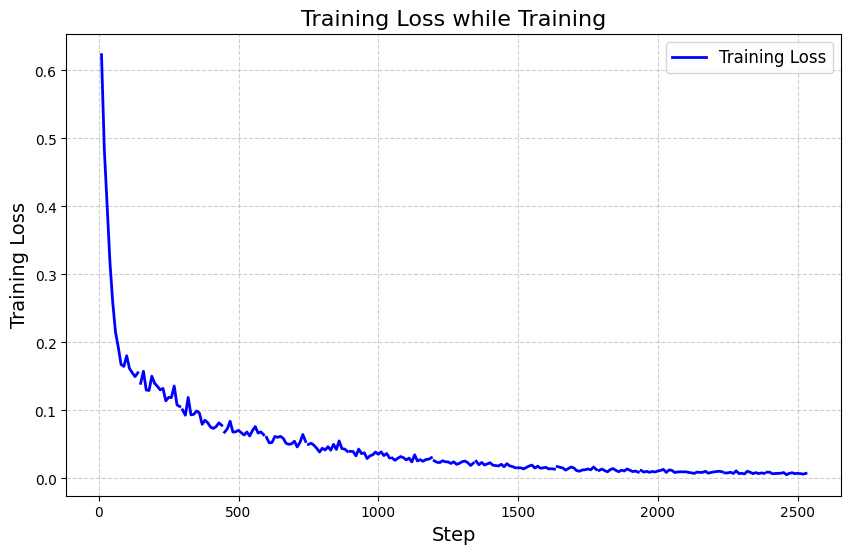

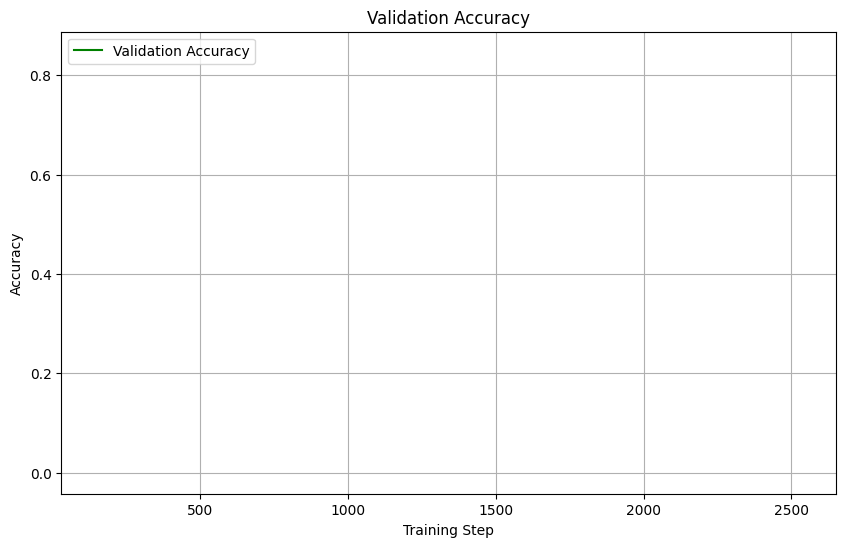

In [18]:
# EVAL FROM CSV DATA

import pandas as pd
import matplotlib.pyplot as plt

# pathes
Distilbert_multi_csv_path = "/content/drive/My Drive/training_metrics_distilbert_multi_select.csv"

# Lade die CSV-Datei
metrics_df = pd.read_csv(Distilbert_multi_csv_path)

# Filtere nur Zeilen mit eval-Metriken (jede Epoche)
epoch_metrics = metrics_df[metrics_df['eval_loss'].notna()]

# Wähle relevante Spalten aus
summary_table = epoch_metrics[['epoch', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']]

# Umbenennen der Spalten für Klarheit
summary_table.rename(columns={
    'eval_loss': 'Validation Loss',
    'eval_accuracy': 'Accuracy',
    'eval_f1': 'F1',
    'eval_precision': 'Precision',
    'eval_recall': 'Recall'
}, inplace=True)

# Anzeige der Tabelle
print(summary_table)

#Train Loss
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['step'], metrics_df['loss'], label='Training Loss', color='blue', linewidth=2)
plt.title("Training Loss while Training", fontsize=16)
plt.xlabel("Step", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

# Accuracy
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['step'], metrics_df['eval_accuracy'], label='Validation Accuracy', color='green')
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [25]:
# Datatables for all trained models

import pandas as pd

# Pfade der CSV-Dateien
csv_paths = {
    #"distilbert_single": "/content/drive/My Drive/training_metrics_distilbert_single_select.csv",
    "distilbert_multi": "/content/drive/My Drive/training_metrics_distilbert_multi_select.csv",
   # "roberta_single": "/content/drive/My Drive/training_metrics_roberta_single_select.csv",
   # "roberta_multi": "/content/drive/My Drive/training_metrics_roberta_multi_select.csv"
   # "lama_single": "/content/drive/My Drive/training_metrics_lama_single_select.csv"
}

# Funktion zur Verarbeitung und Erstellung der Zusammenfassung
def process_metrics(csv_path, model_name):
    try:
        # Lade die CSV-Datei
        metrics_df = pd.read_csv(csv_path)

        # Filtere nur Zeilen mit eval-Metriken (jede Epoche)
        epoch_metrics = metrics_df[metrics_df['eval_loss'].notna()]

        # Wähle relevante Spalten aus und erstelle die Zusammenfassung
        summary_table = epoch_metrics[['epoch', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']].copy()

        # Spalten umbenennen
        summary_table.rename(columns={
            'eval_loss': 'Validation Loss',
            'eval_accuracy': 'Accuracy',
            'eval_f1': 'F1',
            'eval_precision': 'Precision',
            'eval_recall': 'Recall'
        }, inplace=True)

        # Ausgabe der Tabelle im Terminal
        print(f"\nZusammenfassung für {model_name}:\n")
        print(summary_table)

        # Speichern der Tabelle als CSV
        summary_csv_path = f"/content/drive/My Drive/summary_{model_name}.csv"
        summary_table.to_csv(summary_csv_path, index=False)
        print(f"Zusammenfassung wurde erfolgreich unter {summary_csv_path} gespeichert.")

    except Exception as e:
        print(f"Fehler beim Verarbeiten der Datei {csv_path} für {model_name}: {e}")

# Iteriere durch alle Modelle und CSV-Pfade
for model_name, csv_path in csv_paths.items():
    process_metrics(csv_path, model_name)


Fehler beim Verarbeiten der Datei /content/drive/My Drive/training_metrics_distilbert_single_select.csv für distilbert_single: [Errno 2] No such file or directory: '/content/drive/My Drive/training_metrics_distilbert_single_select.csv'

Zusammenfassung für distilbert_multi:

     epoch  Validation Loss  Accuracy        F1  Precision    Recall
14     1.0         0.144671  0.000000  0.000000   0.000000  0.000000
30     2.0         0.096253  0.053691  0.107475   0.118172  0.110368
46     3.0         0.072442  0.127517  0.367418   0.450304  0.357860
62     4.0         0.058009  0.241611  0.501351   0.560340  0.488294
78     5.0         0.051477  0.322148  0.546684   0.688350  0.501672
94     6.0         0.043218  0.416107  0.696597   0.753462  0.692308
110    7.0         0.035290  0.583893  0.786696   0.836965  0.769231
126    8.0         0.029538  0.644295  0.791799   0.824725  0.782609
142    9.0         0.026515  0.671141  0.841609   0.911120  0.812709
158   10.0         0.024476  0.718

CSV-Datei erfolgreich geladen.
     epoch  Validation Loss  Accuracy        F1  Precision    Recall
14     1.0         0.144671  0.000000  0.000000   0.000000  0.000000
30     2.0         0.096253  0.053691  0.107475   0.118172  0.110368
46     3.0         0.072442  0.127517  0.367418   0.450304  0.357860
62     4.0         0.058009  0.241611  0.501351   0.560340  0.488294
78     5.0         0.051477  0.322148  0.546684   0.688350  0.501672
94     6.0         0.043218  0.416107  0.696597   0.753462  0.692308
110    7.0         0.035290  0.583893  0.786696   0.836965  0.769231
126    8.0         0.029538  0.644295  0.791799   0.824725  0.782609
142    9.0         0.026515  0.671141  0.841609   0.911120  0.812709
158   10.0         0.024476  0.718121  0.863325   0.940241  0.836120
173   11.0         0.020905  0.744966  0.892452   0.947289  0.866221
189   12.0         0.020642  0.751678  0.887836   0.943618  0.866221
205   13.0         0.018516  0.812081  0.927038   0.965942  0.906355
221

<ipython-input-11-beb28f3dac35>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table.rename(columns={


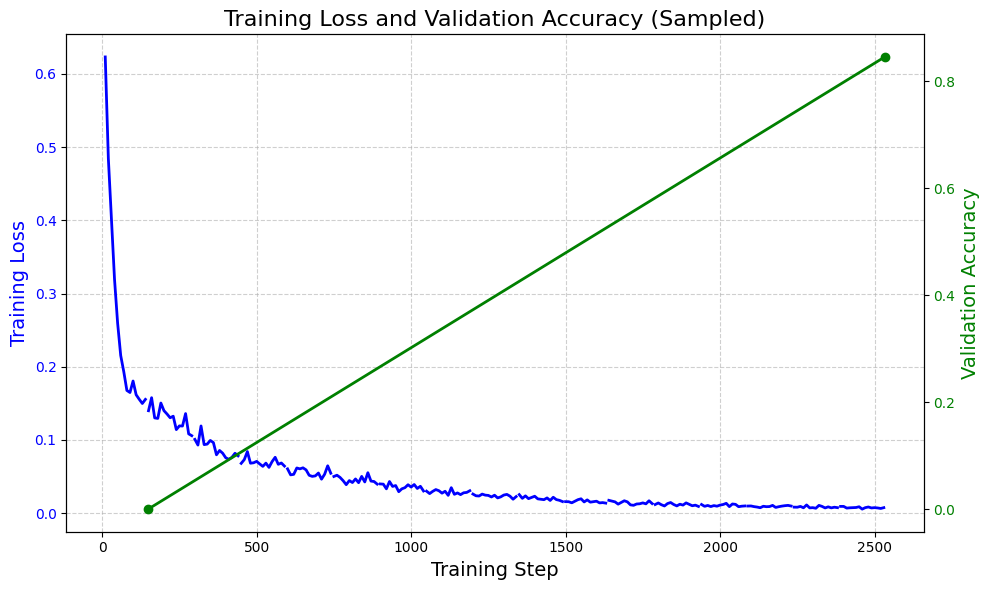

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

# Pfad zur CSV-Datei
csv_path = "/content/drive/My Drive/training_metrics_distilbert_multi_select.csv"

# Lade die CSV-Datei
try:
    metrics_df = pd.read_csv(csv_path)
    print("CSV-Datei erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden der CSV-Datei: {e}")

# Filtere nur Zeilen mit eval-Metriken (jede Epoche)
epoch_metrics = metrics_df[metrics_df['eval_loss'].notna()]

# Wähle relevante Spalten aus
summary_table = epoch_metrics[['epoch', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']]

# Umbenennen der Spalten für Klarheit
summary_table.rename(columns={

    'eval_loss': 'Validation Loss',
    'eval_accuracy': 'Accuracy',
    'eval_f1': 'F1',
    'eval_precision': 'Precision',
    'eval_recall': 'Recall'
}, inplace=True)

# Anzeige der Tabelle
print(summary_table)

# Speichere die Übersicht in eine neue CSV-Datei
summary_csv_path = "/content/drive/My Drive/training_summary_distilbert_multi_select.csv"
summary_table.to_csv(summary_csv_path, index=False)
print(f"Zusammenfassung wurde erfolgreich unter {summary_csv_path} gespeichert.")


# Pfad zur CSV-Datei
csv_path = "/content/drive/My Drive/training_metrics_distilbert_multi_select.csv"

# Lade die CSV-Datei
try:
    metrics_df = pd.read_csv(csv_path)
    print("CSV-Datei erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden der CSV-Datei: {e}")

# Filter: Alle 16. Reihe für `eval_accuracy`
eval_data = metrics_df[metrics_df['eval_accuracy'].notna()].iloc[::16]

# Erstelle eine Figur und Achsen
fig, ax1 = plt.subplots(figsize=(10, 6))

# Training Loss auf der linken y-Achse
ax1.plot(metrics_df['step'], metrics_df['loss'], label='Training Loss', color='blue', linewidth=2)
ax1.set_xlabel("Training Step", fontsize=14)
ax1.set_ylabel("Training Loss", color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Validation Accuracy auf der rechten y-Achse (nur gefilterte Daten)
ax2 = ax1.twinx()
ax2.plot(eval_data['step'], eval_data['eval_accuracy'], label='Validation Accuracy', color='green', linewidth=2, marker='o')
ax2.set_ylabel("Validation Accuracy", color='green', fontsize=14)
ax2.tick_params(axis='y', labelcolor='green')

# Titel und Legenden
plt.title("Training Loss and Validation Accuracy (Sampled)", fontsize=16)
fig.tight_layout()  # Layout anpassen
plt.show()


Daten erfolgreich geladen.
     loss  grad_norm  learning_rate     epoch  step  eval_loss  eval_accuracy  \
0  0.6232   0.685356       0.000050  0.067114    10        NaN            NaN   
1  0.4847   0.693651       0.000050  0.134228    20        NaN            NaN   
2  0.4026   0.647607       0.000050  0.201342    30        NaN            NaN   
3  0.3194   0.604423       0.000049  0.268456    40        NaN            NaN   
4  0.2597   0.517130       0.000049  0.335570    50        NaN            NaN   

   eval_f1  eval_precision  eval_recall  eval_runtime  \
0      NaN             NaN          NaN           NaN   
1      NaN             NaN          NaN           NaN   
2      NaN             NaN          NaN           NaN   
3      NaN             NaN          NaN           NaN   
4      NaN             NaN          NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
1      

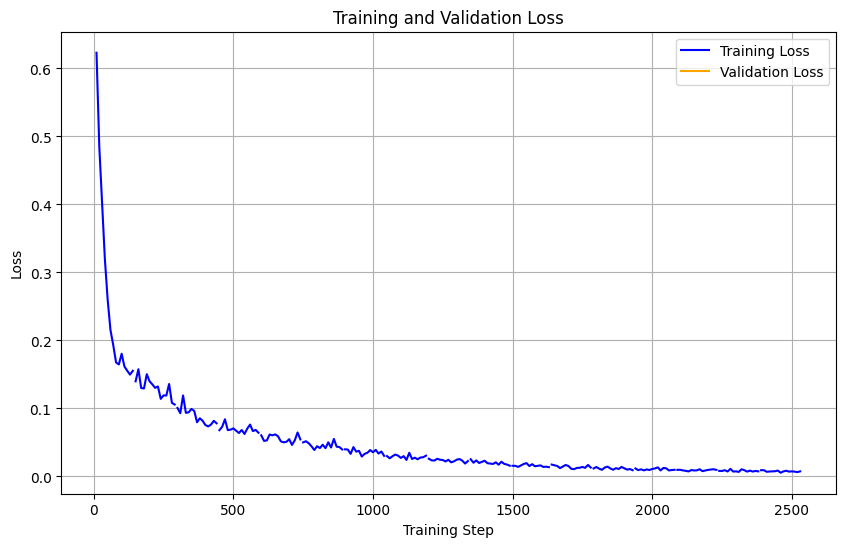

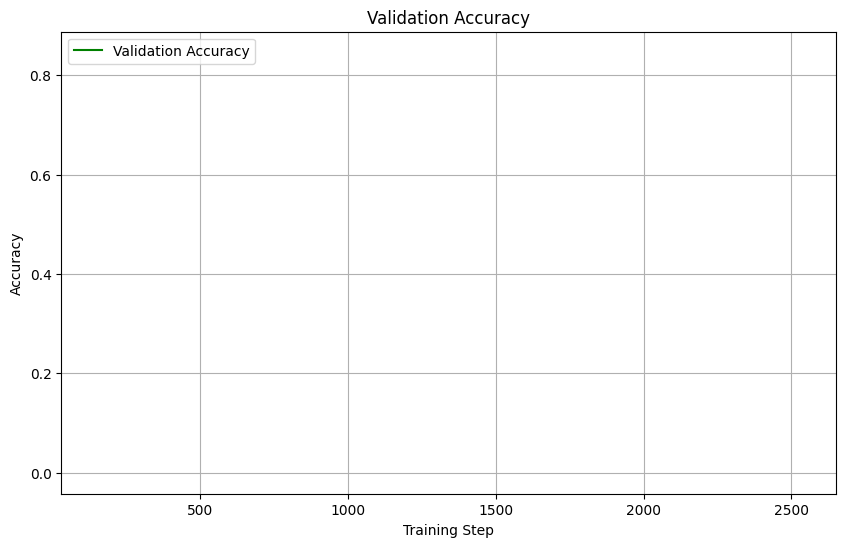

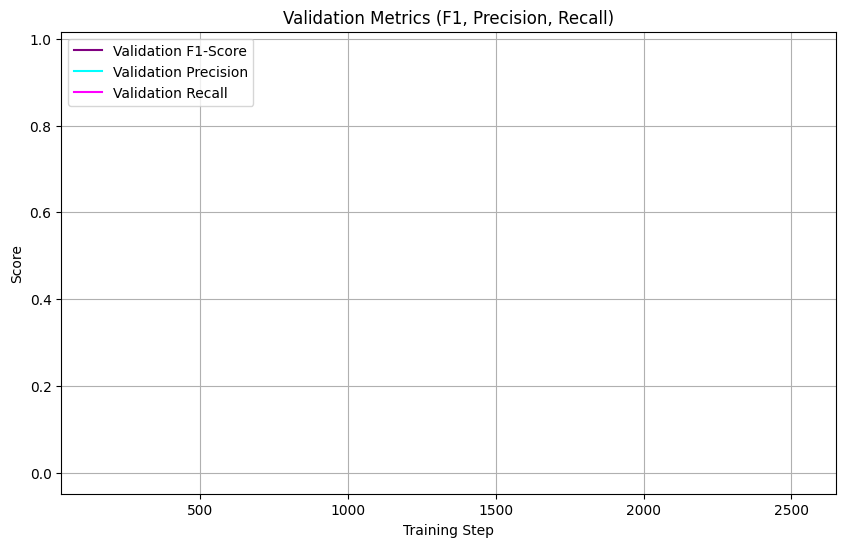

Beste Ergebnisse:
Step: 2533.0
Validation Accuracy: 0.8456375838926175
Validation F1: 0.9294419504447554
Validation Precision: 0.9641304347826086
Validation Recall: 0.9096989966555185


OSError: Cannot save file into a non-existent directory: '/path/to'

In [1]:
# EVAL FROM CSV DATA

import pandas as pd
import matplotlib.pyplot as plt

# pathes
Distilbert_multi_csv_path = "/content/drive/My Drive/training_metrics_distilbert_multi_select.csv"
# Lade die CSV-Datei
try:
    metrics_df = pd.read_csv(csv_path)
    print("Daten erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden der Datei: {e}")
    exit()

# Vorschau der Daten
print(metrics_df.head())

# Konvertiere Spaltennamen in Kleinbuchstaben für einfachere Nutzung
metrics_df.columns = [col.lower() for col in metrics_df.columns]

# Plot 1: Trainings- und Validierungsverlust über die Epochen
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['step'], metrics_df['loss'], label='Training Loss', color='blue')
plt.plot(metrics_df['step'], metrics_df['eval_loss'], label='Validation Loss', color='orange')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot 2: Genauigkeit (Accuracy) über die Trainingsschritte
if 'eval_accuracy' in metrics_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['step'], metrics_df['eval_accuracy'], label='Validation Accuracy', color='green')
    plt.xlabel("Training Step")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Plot 3: F1-Score, Precision, Recall
if {'eval_f1', 'eval_precision', 'eval_recall'}.issubset(metrics_df.columns):
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['step'], metrics_df['eval_f1'], label='Validation F1-Score', color='purple')
    plt.plot(metrics_df['step'], metrics_df['eval_precision'], label='Validation Precision', color='cyan')
    plt.plot(metrics_df['step'], metrics_df['eval_recall'], label='Validation Recall', color='magenta')
    plt.xlabel("Training Step")
    plt.ylabel("Score")
    plt.title("Validation Metrics (F1, Precision, Recall)")
    plt.legend()
    plt.grid()
    plt.show()

# Zusammenfassung der besten Ergebnisse
best_row = metrics_df.loc[metrics_df['eval_accuracy'].idxmax()]
print("Beste Ergebnisse:")
print(f"Step: {best_row['step']}")
print(f"Validation Accuracy: {best_row['eval_accuracy']}")
print(f"Validation F1: {best_row['eval_f1']}")
print(f"Validation Precision: {best_row['eval_precision']}")
print(f"Validation Recall: {best_row['eval_recall']}")

# Optional: Speichere die besten Ergebnisse in einer neuen CSV
best_results = metrics_df.loc[[metrics_df['eval_accuracy'].idxmax()]]
best_results.to_csv("/path/to/best_results.csv", index=False)
print("Beste Ergebnisse wurden gespeichert.")


In [42]:
# FINAL MERGE DISTIL ROBERTA


import json
import random
import ipywidgets as widgets
from IPython.display import display
import torch
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# Laden der Datensätze
single_dataset_path = '/content/drive/My Drive/ColabData/final_single_question_data.json'
multi_dataset_path = '/content/drive/My Drive/ColabData/final_multi_question_data.json'

with open(single_dataset_path, 'r') as file:
    single_dataset = json.load(file)

with open(multi_dataset_path, 'r') as file:
    multi_dataset = json.load(file)

# Funktion zum Extrahieren der Fragen aus den Datensätzen
def extract_questions(dataset):
    return [item['question'] for item in dataset if 'question' in item]

# Fragen aus den Datensätzen extrahieren
single_questions = extract_questions(single_dataset)
multi_questions = extract_questions(multi_dataset)

# Kombinierte Fragenliste und Typzuweisung
all_questions = [(q, 'single') for q in single_questions] + [(q, 'multi') for q in multi_questions]

# Zufällige Frage auswählen
def get_random_question():
    return random.choice(all_questions)

# Pfade der Modelle
model_paths = {
    "distilbert_single": "/content/drive/My Drive/final_model",
    "roberta_single": "/content/drive/My Drive/roberta_classification_single_select",
    "distilbert_multi": "/content/drive/My Drive/multi_distilbert_wQ",
    "roberta_multi": "/content/drive/My Drive/roberta_classification_multi_select"
}

# Laden der Modelle und Tokenizer
models = {key: AutoModelForSequenceClassification.from_pretrained(path) for key, path in model_paths.items()}
tokenizers = {key: AutoTokenizer.from_pretrained(path) for key, path in model_paths.items()}

# Laden der Label-Mappings
single_label_mapping_path = '/content/drive/My Drive/single_label_mapping.pkl'
multi_label_mapping_path = '/content/drive/My Drive/label_mapping_multi_wQ.pkl'

with open(single_label_mapping_path, 'rb') as file:
    single_label_mapping = pickle.load(file)

with open(multi_label_mapping_path, 'rb') as file:
    multi_label_mapping = pickle.load(file)

def on_new_question(b):
    question, question_type = get_random_question()
    question_text.value = f"{question}||{question_type}"  # Kombiniere die Frage mit dem Typ im richtigen Format
    answer_text.value = ""
    output_label.value = "Waiting for input..."
    with heatmap_output:
        heatmap_output.clear_output()

def on_predict(b):
    question_with_type = question_text.value
    if "||" not in question_with_type:
        output_label.value = "Invalid input format. Please reload a question."
        return

    question, question_type = question_with_type.split("||")
    answer = answer_text.value

    predictions, heatmaps = predict_answer(question, answer, question_type)

    # Ausgabe der Ergebnisse
    output_label.value = (
        f"<b>Question Type:</b> {question_type.capitalize()}<br>"
        f"<b>DistilBERT Prediction:</b> {', '.join(predictions['distilbert_single' if question_type == 'single' else 'distilbert_multi'])}<br>"
        f"<b>Roberta Prediction:</b> {', '.join(predictions['roberta_single' if question_type == 'single' else 'roberta_multi'])}"
    )

    # Heatmaps anzeigen
    with heatmap_output:
        heatmap_output.clear_output()
        display(widgets.HBox([
            widgets.Image(value=heatmaps['distilbert_single' if question_type == 'single' else 'distilbert_multi'], format="png", width=600, height=300),
            widgets.Image(value=heatmaps['roberta_single' if question_type == 'single' else 'roberta_multi'], format="png", width=600, height=300)
        ]))



# Funktion zur Erstellung einer Heatmap
def create_heatmap(probabilities, label_mapping, title="Heatmap"):
    plt.figure(figsize=(12, 4))
    labels = [label_mapping[idx] for idx in range(len(label_mapping))]
    plt.imshow([probabilities], cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="Probability")
    plt.yticks([])
    plt.xticks(range(len(probabilities)), labels, rotation=90)
    plt.title(title)
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    image_bytes = buf.read()
    buf.close()
    plt.close()
    return image_bytes

# Vorhersage-Funktion
def predict_answer(question, answer, question_type, multi_threshold=0.3):
    model_keys = [
        "distilbert_single" if question_type == 'single' else "distilbert_multi",
        "roberta_single" if question_type == 'single' else "roberta_multi"
    ]
    label_mapping = single_label_mapping if question_type == 'single' else multi_label_mapping

    predictions = {}
    heatmaps = {}

    for model_key in model_keys:
        tokenizer = tokenizers[model_key]
        model = models[model_key]
        inputs = tokenizer(question, answer, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.sigmoid(logits).squeeze().tolist()

            if question_type == 'single':
                # **For single questions, return only the highest probability label**
                predicted_index = torch.argmax(torch.tensor(probabilities)).item()
                predicted_labels = [label_mapping.get(predicted_index, f"Unknown ({predicted_index})")]
            else:
                # **For multi questions, use threshold-based predictions**
                predicted_indices = [idx for idx, prob in enumerate(probabilities) if prob > multi_threshold]
                predicted_labels = [label_mapping.get(idx, f"Unknown ({idx})") for idx in predicted_indices]

            predictions[model_key] = predicted_labels if predicted_labels else "No Labels predicted"
            heatmaps[model_key] = create_heatmap(probabilities, label_mapping, title=f"{model_key} Heatmap")

    return predictions, heatmaps

# UI Widgets
question_text = widgets.Text(
    value="",
    description="Question:",
    layout=widgets.Layout(width="80%")  # Breite der Eingabefelder anpassen
)
answer_text = widgets.Text(
    description="Answer:",
    layout=widgets.Layout(width="80%")  # Breite der Eingabefelder anpassen
)

predict_button = widgets.Button(description="Predict")
new_question_button = widgets.Button(description="New Question")
output_label = widgets.HTML(value="Waiting for input...")
heatmap_output = widgets.Output()

predict_button.on_click(on_predict)
new_question_button.on_click(on_new_question)

# Initiale Frage laden
on_new_question(None)

# UI anzeigen
display(widgets.VBox([
    question_text,
    answer_text,
    widgets.HBox([predict_button, new_question_button]),
    output_label,
    heatmap_output
]))
